In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
from multiprocessing import Pool
import time,gc

In [2]:
# f21:上一天非周期用户的数量(一天只有两次刷卡)
# 分时刻重复上述特征

In [9]:
# 统计进出站每天的变化情况
def get_daily_activity(i):
    if i<10:
        s = '0'+str(i)
    else:
        s = str(i)
    day_activ = pd.read_csv('data/Metro_train/record_2019-01-%s.csv'%s)
    day_activ['time'] = pd.to_datetime(day_activ.time)
    day_activ['stationID'] = day_activ['stationID']
    day_activ['deviceID'] = day_activ['deviceID']
    day_activ['status'] = day_activ['status']
    day_activ['payType'] = day_activ['payType']
    day_activ['lineID'] = day_activ['lineID'].apply(lambda x: {'A':0,'B':2,'C':1}[x])
    return day_activ

def construct_df():
    final = pd.DataFrame()
    for i in range(81):
        temp = pd.DataFrame()
        temp['minute'] = list(range(1440))
        temp['stationID'] = i
        final = final.append(temp)
    final['minute'] = final['minute']/10
    return final


In [13]:
all_df = pd.DataFrame()

#for date in range(7,26):
for date in tqdm([12,13,14,19,20,21,26,28]):
    final = construct_df()
    day_activ = get_daily_activity(date)
    day_activ = day_activ[day_activ.status==0]
    userid_count = day_activ.groupby(['userID'],as_index=False).agg({'status':'count'})\
    .rename(columns={'status':'come_count'})
    user_id_group = userid_count[userid_count.come_count==1]['userID']
    user_id_group_1 = set(user_id_group.values)
    user_id_group = userid_count[userid_count.come_count==2]['userID']
    user_id_group_2 = set(user_id_group.values)
    def find_time(t):
        if t in user_id_group_1:
            return 1
        elif t in user_id_group_2:
            return 2
        else:
            return 3
    day_activ['come_time'] = day_activ['userID'].apply(lambda x:find_time(x))
    day_activ['user_type'] = day_activ['come_time'].astype('str')+'_'+ day_activ['payType'].astype('str')
    
    df = pd.DataFrame()
    for i in range(10):
        day_activ['minute'] = (day_activ['time'].dt.minute-i+day_activ['time'].dt.hour*60)//10+0.1*i
        day_activ['minute'] = day_activ['minute'].apply(lambda x:143+1+x if x<0 else x)
        df = df.append(day_activ)

    df = day_activ
    df.sort_values(by='minute',inplace=True)
    come = df
    
    for item in day_activ['user_type'].unique():
        f1 = come[come.user_type==item].groupby(['stationID','minute'],as_index=False).agg({'user_type':'count'}).\
        rename(columns={'user_type':item})
        final = final.merge(f1,on=['stationID','minute'],how='left')
    final.fillna(0,inplace=True)
#     # 上一天非周期用户的数量(一天只有两次刷卡) 进站一次 进站二次 比率
#     f1 = come.groupby(['stationID','minute'],as_index=False).agg({'once_come':'sum'}).\
#     rename(columns={'once_come':'once_come_by_s_m'})
#     final = final.merge(f1,on=['stationID','minute'],how='left')
#     f2 = come.groupby(['stationID','minute'],as_index=False).agg({'twice_come':'sum'}).rename(columns={'twice_come':'twice_come_by_s_m'})
#     final = final.merge(f2,on=['stationID','minute'],how='left')
#     final['twice_to_once_come_s_m'] = final['once_come_by_s_m']/final['twice_come_by_s_m']
    
#     f3 = come.groupby('stationID').agg({'once_come':'sum'}).rename(columns={'once_come':'once_come_by_s'})
#     final = final.merge(f3,on='stationID',how='left')
#     f4 = come.groupby('stationID').agg({'twice_come':'sum'}).rename(columns={'twice_come':'twice_come_by_s'})
#     final = final.merge(f4,on='stationID',how='left')
#     final['twice_to_once_come_s'] = final['once_come_by_s']/final['twice_come_by_s']
    
#     f5 = come.groupby('minute').agg({'once_come':'sum'}).rename(columns={'once_come':'once_come_by_m'})
#     final = final.merge(f5,on='minute',how='left')
#     f6 = come.groupby('minute').agg({'twice_come':'sum'}).rename(columns={'twice_come':'twice_come_by_m'})
#     final = final.merge(f6,on='minute',how='left')
#     final['twice_to_once_come_m'] = final['once_come_by_m']/final['twice_come_by_m']
#     # 数据格式减少内存
    final['date'] = date
#     final.fillna(0,inplace=True)
#     for c in final.dtypes.index:
#         if final.dtypes[c] == 'float64':
#             final[c] = final[c].astype('float32')
    all_df = all_df.append(final)
    #break

100%|██████████| 8/8 [03:46<00:00, 29.90s/it]


In [1]:
all_df.shape

NameError: name 'all_df' is not defined

In [15]:
all_df.to_pickle('features/out_type.pkl')

In [233]:
day_activ['payType'].value_counts()

1    496726
2    374735
0    173298
3    157888
Name: payType, dtype: int64

In [119]:
all_df.to_pickle('features/explore.pkl')

In [234]:
day_activ['user_type'].unique()

array(['2_0', '3_1', '3_2', '1_1', '2_1', '1_3', '1_2', '3_3', '2_3',
       '3_0', '1_0', '2_2'], dtype=object)

In [235]:
agg_item = dict(zip(day_activ['user_type'].unique(),['sum']*12))

In [293]:
f_g = all_df.groupby('date',as_index=False).agg(agg_item)
f_g['星期'] = (f_g.index)%7+1

In [284]:
# f_g

In [320]:
f_g = all_df[all_df.stationID==26].groupby('date',as_index=False).agg(agg_item)
f_g['星期'] = (f_g.index)%7+1

In [321]:
day_activ['payType'].value_counts()

1    496726
2    374735
0    173298
3    157888
Name: payType, dtype: int64

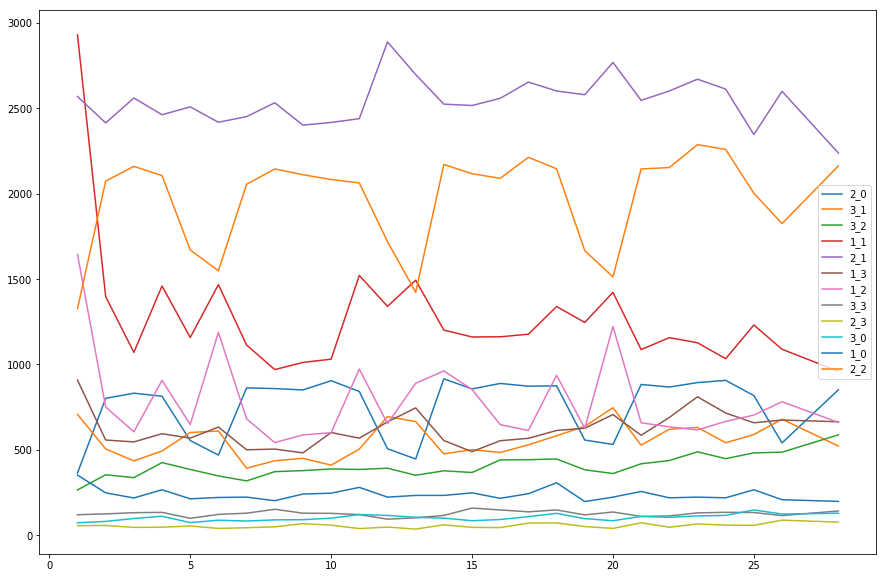

In [322]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10)) 
a = np.zeros(27)
for item in day_activ['user_type'].unique():
    #if item[-1]!='3':continue
    plt.plot(f_g.date,f_g[item])
    a = a+np.array(list(f_g[item]))
    plt.legend(loc='best')
    #plt.figure()
plt.show()
# 3 点卡 
# 1 二维码
# 2 公交卡
# 0 NFC

In [296]:
a

array([1269045., 1188663., 1147002., 1212307., 1011043.,  974441.,
       1129221., 1152871., 1141438., 1159623., 1251866., 1084767.,
       1032358., 1199228., 1152828., 1209108., 1237837., 1332770.,
       1104846., 1056825., 1233048., 1238371., 1262212., 1258497.,
       1287602., 1121707., 1202647.])

In [282]:
all_df[(all_df.stationID==15)&(all_df.date==26)].loc[:,day_activ['user_type'].unique()].sum()

2_0     1952.0
3_1     5365.0
3_2     1902.0
1_1    33542.0
2_1    14090.0
1_3    23772.0
1_2     9600.0
3_3      349.0
2_3     1818.0
3_0      714.0
1_0     3707.0
2_2     5057.0
dtype: float64

In [324]:
# f_g['1_1']

In [265]:
day_activ['user_type'].unique()

array(['2_0', '3_1', '3_2', '1_1', '2_1', '1_3', '1_2', '3_3', '2_3',
       '3_0', '1_0', '2_2'], dtype=object)

In [ ]:
c_1 = ['3_2','3_0'] # 老年商人
c_2 = ['3_1'] # 年轻人游玩
c_3 = ['1_0','1_1','1_2'] # 游客+白领返乡
c_4 = ['2_1','2_2'] # 上班族
c_5 = ['1_3'] # 农民工
c_6 = ['2_3','2_0'] # 上班族


In [323]:
all_df[all_df.date==26].groupby('stationID').agg({'count':'sum'}).sort_values(by='count').tail()

,count
stationID,
8,28500.0
10,32971.0
7,52226.0
9,70136.0
15,101868.0


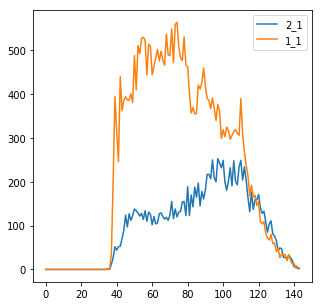

In [241]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,5)) 
day = all_df[(all_df.date==26)&(all_df.stationID==15)]
day2 = all_df[(all_df.date==26)&(all_df.stationID==15)]

#for item in day_activ['user_type'].unique():
#if item[-1]!='3':continue
plt.plot(day['minute'],day['2_1'])
plt.plot(day['minute'],day['1_1'])

plt.legend(loc='best')
#plt.figure()
plt.show()
# 3 点卡 
# 1 二维码
# 2 公交卡
# 0 NFC

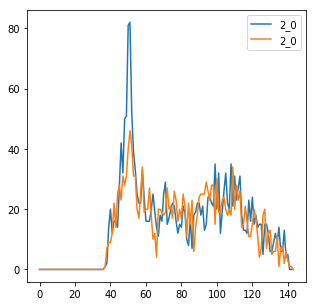

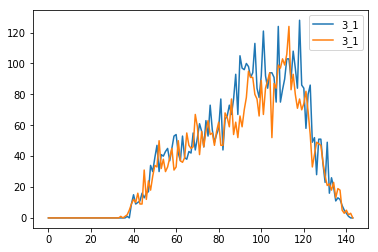

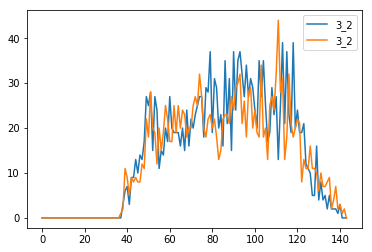

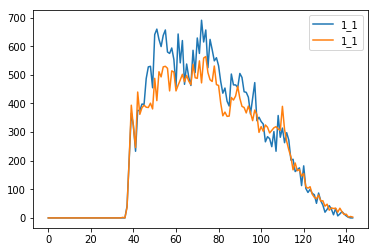

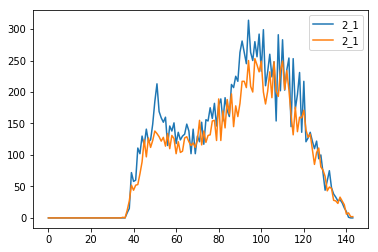

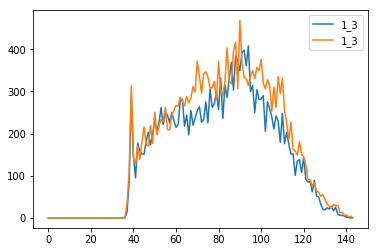

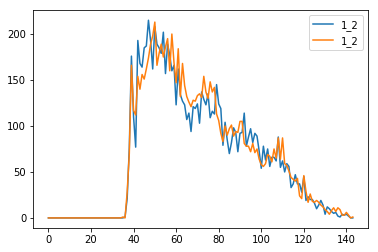

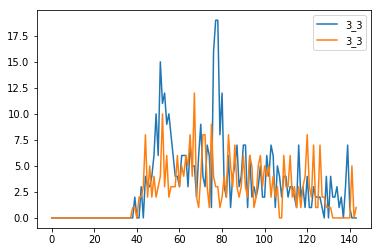

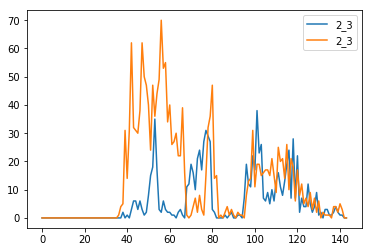

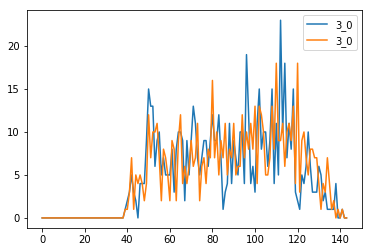

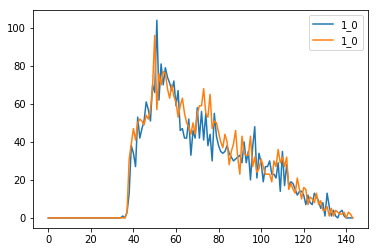

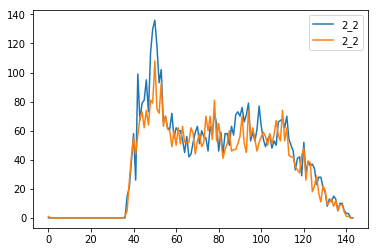

In [319]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,5)) 
day = all_df[(all_df.date==19)&(all_df.stationID==15)]
day2 = all_df[(all_df.date==26)&(all_df.stationID==15)]

#for item in day_activ['user_type'].unique():
#if item[-1]!='3':continue
for d in agg_item.keys():
    plt.plot(day['minute'],day[d])
    plt.plot(day2['minute'],day2[d])

    plt.legend(loc='best')
    #plt.figure()
    plt.show()
    # 3 点卡 
    # 1 二维码
    # 2 公交卡
    # 0 NFC

In [317]:
all_df['count'] = all_df.loc[:,day_activ['user_type'].unique()].sum(axis=1)

In [301]:
all_df[(all_df.date==26)&(all_df.stationID==1)]['count'].sum()

5913.0

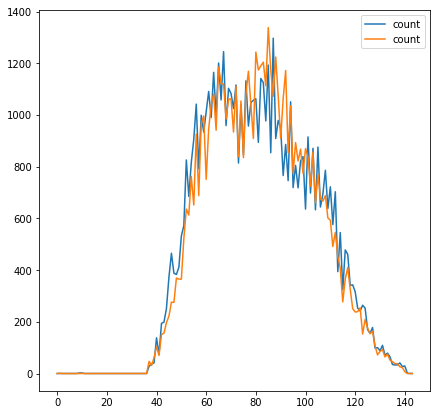

In [303]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7)) 
day0 = all_df[(all_df.date==12)&(all_df.stationID==15)]
day = all_df[(all_df.date==19)&(all_df.stationID==9)]
day2 = all_df[(all_df.date==20)&(all_df.stationID==9)]

#for item in day_activ['user_type'].unique():
#if item[-1]!='3':continue
#plt.plot(day0['minute'],day0['count'])
plt.plot(day['minute'],day['count'])
plt.plot(day2['minute'],day2['count'])

plt.legend(loc='best')
#plt.figure()
plt.show()
# 3 点卡 
# 1 二维码
# 2 公交卡
# 0 NFC

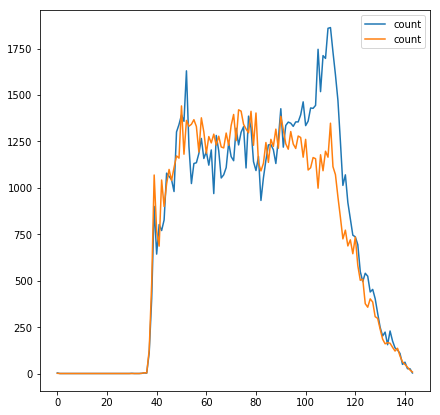

In [328]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7)) 
day0 = all_df[(all_df.date==12)&(all_df.stationID==15)]
day = all_df[(all_df.date==25)&(all_df.stationID==15)]
day2 = all_df[(all_df.date==26)&(all_df.stationID==15)]

#for item in day_activ['user_type'].unique():
#if item[-1]!='3':continue
#plt.plot(day0['minute'],day0['count'])
plt.plot(day['minute'],day['count'])
plt.plot(day2['minute'],day2['count'])

plt.legend(loc='best')
#plt.figure()
plt.show()
# 3 点卡 
# 1 二维码
# 2 公交卡
# 0 NFC

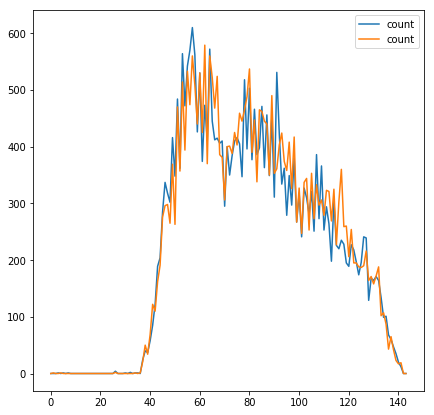

In [351]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7)) 
#day0 = all_df[(all_df.date==12)&(all_df.stationID==15)]
day = all_df[(all_df.date==12)&(all_df.stationID==7)]
day2 = all_df[(all_df.date==13)&(all_df.stationID==7)]

#for item in day_activ['user_type'].unique():
#if item[-1]!='3':continue
#plt.plot(day0['minute'],day0['count'])
plt.plot(day['minute'],day['count'])
plt.plot(day2['minute'],day2['count'])

plt.legend(loc='best')
#plt.figure()
plt.show()
# 3 点卡 
# 1 二维码
# 2 公交卡
# 0 NFC

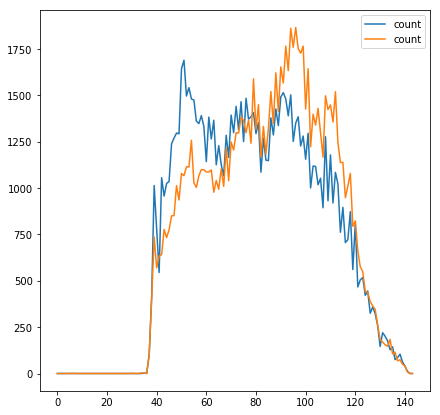

In [352]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7)) 
#day0 = all_df[(all_df.date==12)&(all_df.stationID==1)]
day = all_df[(all_df.date==19)&(all_df.stationID==1)]
day2 = all_df[(all_df.date==20)&(all_df.stationID==15)]

#for item in day_activ['user_type'].unique():
#if item[-1]!='3':continue
#plt.plot(day0['minute'],day0['count'])
plt.plot(day['minute'],day['count'])
plt.plot(day2['minute'],day2['count'])

plt.legend(loc='best')
#plt.figure()
plt.show()
# 3 点卡 
# 1 二维码
# 2 公交卡
# 0 NFC

In [353]:
out = pd.read_pickle('out.pkl')

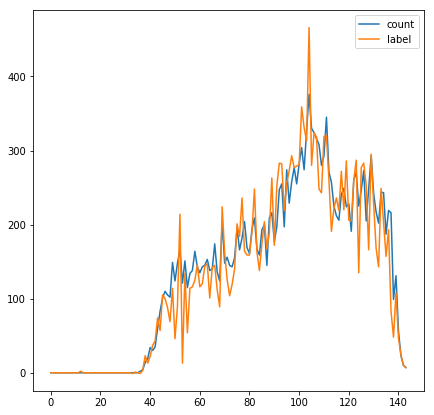

In [359]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7)) 
#day0 = all_df[(all_df.date==12)&(all_df.stationID==1)]

day = all_df[(all_df.date==26)&(all_df.stationID==14)]
day2 = out[(out.stationID==14)]

#for item in day_activ['user_type'].unique():
#if item[-1]!='3':continue
#plt.plot(day0['minute'],day0['count'])
plt.plot(day['minute'],day['count'])
plt.plot(day2['minute'],day2['label'])

plt.legend(loc='best')
#plt.figure()
plt.show()
# 3 点卡 
# 1 二维码
# 2 公交卡
# 0 NFC

In [274]:
all_df[(all_df.date==26)&(all_df.stationID==15)]['count'].sum()

101868.0

In [267]:
all_df[(all_df.date==26)&(all_df.stationID==15)]

,1_0,1_1,1_2,1_3,2_0,2_1,2_2,2_3,3_0,3_1,3_2,3_3,date,minute,stationID,count
2160,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26,0,15,1.0
2161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,1,15,0.0
2162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,2,15,0.0
2163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,3,15,0.0
2164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,4,15,0.0
2165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,5,15,0.0
2166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,6,15,0.0
2167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,7,15,0.0
2168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,8,15,0.0
2169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,9,15,0.0


In [218]:
all_df[(all_df.date==19)]['count'].sum()

1104492.0